# Exchange Rate: Recurrent Neural Network

In this chapter we will use recurrent neural networks to predict financial time series related to the EUR/USD exchange rate.

This code is taken from Chapter 8 of *Artificial Intelligence in Finance* by Yves Hilpisch.

## Importing Packages

Let's begin by importing the packages we will need.

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import tensorflow as tf
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

2023-09-02 14:13:55.462630: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-02 14:13:55.626494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-02 14:13:55.627749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 14:13:56.625861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Let's set the random seeds for the various random generators that get used by **tensorflow** and **keras**.

In [ ]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

The `TimeSeriesGenerator` is used to transform raw data into an object that is suited for recurrent neural networks.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

Finally, let's import the layer objects that we will need.  Notice two new layer types: `SimpleRNN` and `LSTM`.

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

## Wrangling Data

Next, let's wrangle our data.

In [ ]:
raw = pd.read_csv('../data/eur_usd.csv', parse_dates=['Date'])
raw.set_index('Date', inplace=True)
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [ ]:
def generate_data():
    data = pd.DataFrame(raw['CLOSE'])
    data.columns = ['EUR_USD']
    data = data.resample('30min', label='right').last().ffill()
    return data

Notice that we are taking 30 minute snapshots.

In [ ]:
data = generate_data()
data.head()

,EUR_USD
Date,
2019-10-01 00:30:00,1.0899
2019-10-01 01:00:00,1.0896
2019-10-01 01:30:00,1.0892
2019-10-01 02:00:00,1.0890
2019-10-01 02:30:00,1.0886


Now let's apply Gaussian normalization.

In [ ]:
data = (data - data.mean()) / data.std()

In [ ]:
p = data['EUR_USD'].values
p = p.reshape((len(p), -1))
p

array([[-2.7112],
       [-2.7583],
       [-2.8211],
       ...,
       [ 2.1877],
       [ 2.1877],
       [ 2.1877]])

## Fitting to `EUR_USD` Directly

As a first step, let's use `TimeseriesGenerator` to put our data in the correct form.

In [ ]:
lags = 5

In [ ]:
g = TimeseriesGenerator(p, p, length=lags, batch_size=5)
list(g)[0]

(array([[[-2.7112],
         [-2.7583],
         [-2.8211],
         [-2.8525],
         [-2.9153]],
 
        [[-2.7583],
         [-2.8211],
         [-2.8525],
         [-2.9153],
         [-2.9153]],
 
        [[-2.8211],
         [-2.8525],
         [-2.9153],
         [-2.9153],
         [-2.9153]],
 
        [[-2.8525],
         [-2.9153],
         [-2.9153],
         [-2.9153],
         [-2.8839]],
 
        [[-2.9153],
         [-2.9153],
         [-2.9153],
         [-2.8839],
         [-2.8525]]]),
 array([[-2.9153],
        [-2.9153],
        [-2.8839],
        [-2.8525],
        [-2.8682]]))

The following user-defined function allows the creation of an RNN with a `SimpleRNN` or `LSTM` layer.

In [ ]:
def create_rnn_model(hu=100, lags=lags, layer='SimpleRNN', 
                     features=1, algorithm='estimation'):
    model = Sequential()
    if layer == 'SimpleRNN':
        model.add(SimpleRNN(hu, activation='relu', input_shape=(lags, features)))
    else:
        model.add(LSTM(hu, activation='relu',input_shape=(lags, features)))
    if algorithm == 'estimation':
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

Next we use the function above to create the RNN model.

In [ ]:
model = create_rnn_model()

We are now ready to fit the model.

In [ ]:
%%time
model.fit(g, epochs=500, steps_per_epoch=10, verbose=False);

CPU times: user 23.8 s, sys: 1.06 s, total: 24.9 s
Wall time: 15.4 s


In [ ]:
y = model.predict(g, verbose=False)
y

array([[-2.7377],
       [-2.7582],
       [-2.7608],
       ...,
       [ 2.1769],
       [ 2.2127],
       [ 2.227 ]], dtype=float32)

Let's take a look at our predictions.

In [ ]:
data['pred'] = np.nan
data['pred'].iloc[lags:] = y.flatten()
data.head(10)

,EUR_USD,pred
Date,,
2019-10-01 00:30:00,-2.711169,NaN
2019-10-01 01:00:00,-2.758273,NaN
2019-10-01 01:30:00,-2.821080,NaN
2019-10-01 02:00:00,-2.852483,NaN
2019-10-01 02:30:00,-2.915289,NaN
2019-10-01 03:00:00,-2.915289,-2.737728
2019-10-01 03:30:00,-2.915289,-2.758190
2019-10-01 04:00:00,-2.883886,-2.760781
2019-10-01 04:30:00,-2.852483,-2.741888


At a first glance our predictions seem quite good.

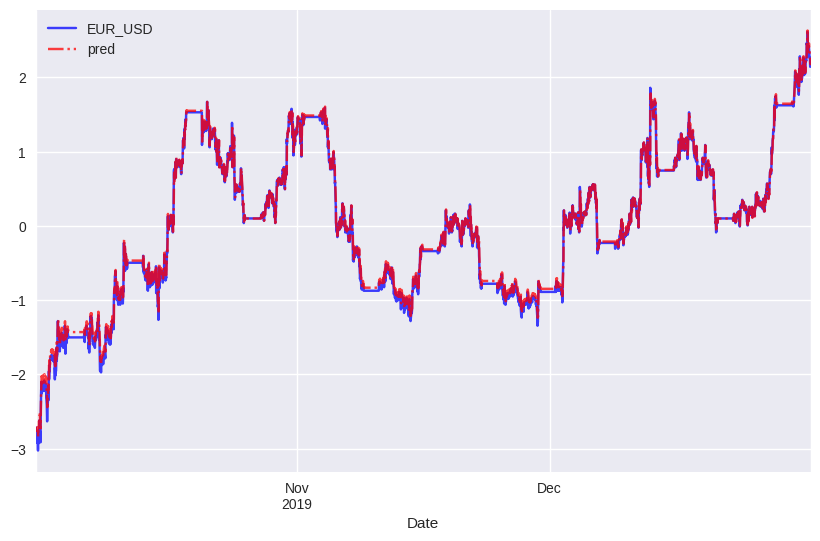

In [ ]:
%matplotlib inline
data[['EUR_USD', 'pred']].plot(figsize=(10, 6), style=['b', 'r-.'],alpha=0.75);

However, by zooming in we can see that our prediction of tommorrow's price is essentially today's price.

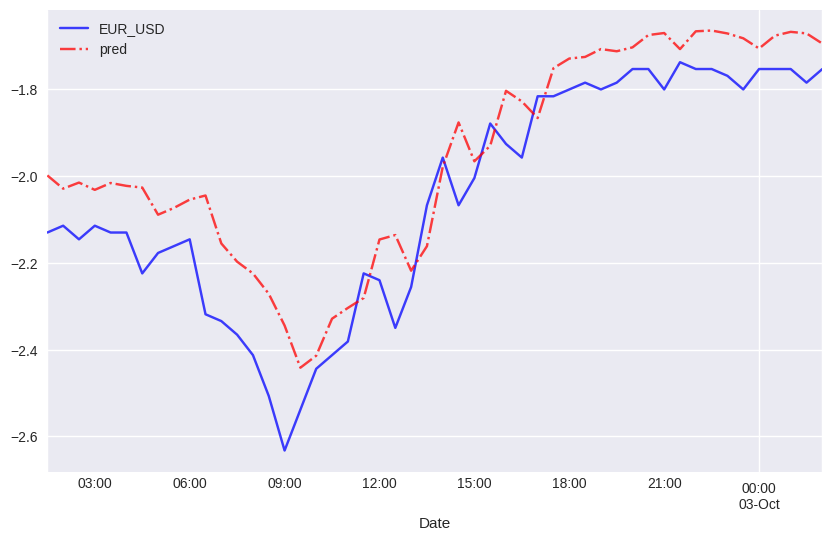

In [ ]:
data[['EUR_USD', 'pred']].iloc[50:100].plot(figsize=(10, 6), style=['b', 'r-.'], alpha=0.75);

## Fitting to `EUR_USD` Returns

In this section we fit an RNN to the returns of `EUR_USD`.  Let's begin by wrangling our data.

In [ ]:
data = generate_data()
data['r'] = np.log(data / data.shift(1)) # calculating returns
data.dropna(inplace=True)
data = (data - data.mean()) / data.std() # normalizing

Next, using `TimeseriesGenerator`, let's put the returns in the correct format to be fed into an RNN model.

In [ ]:
r = data['r'].values
r = r.reshape((len(r), -1))
g = TimeseriesGenerator(r, r, length=lags, batch_size=5)

We are now ready to create and fit our model.

In [ ]:
model = create_rnn_model()

In [ ]:
%%time
model.fit(g, epochs=500, steps_per_epoch=10, verbose=False);

CPU times: user 23.6 s, sys: 1.26 s, total: 24.9 s
Wall time: 15.3 s


In [ ]:
y = model.predict(g, verbose=False)

Let's examine our predictions.

In [ ]:
data['pred'] = np.nan
data['pred'].iloc[lags:] = y.flatten()
data.dropna(inplace=True)
data.head()

,EUR_USD,r,pred
Date,,,
2019-10-01 03:30:00,-2.918004,-0.017915,-0.053734
2019-10-01 04:00:00,-2.886578,0.496771,-0.019448
2019-10-01 04:30:00,-2.855152,0.496676,-0.114525
2019-10-01 05:00:00,-2.870865,-0.275199,-0.121304
2019-10-01 05:30:00,-2.855152,0.239369,-0.006001


If we examine the graph of our predictions versus ground-truth, we find that the order of magnitude of our predictions is off, but directionally the model doesn't do too badly.

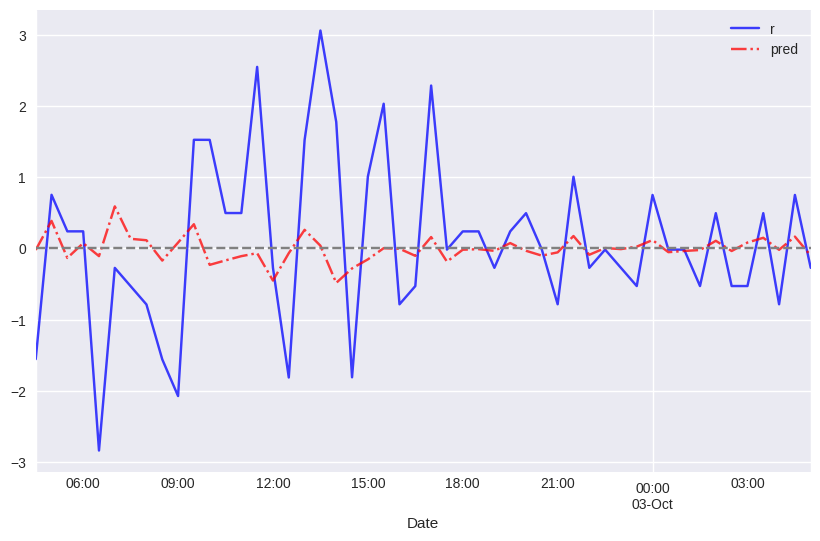

In [ ]:
data[['r', 'pred']].iloc[50:100].plot(figsize=(10, 6), style=['b', 'r-.'], alpha=0.75);
plt.axhline(0, c='grey', ls='--');

Let's check how often we are directionally correct.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.sign(data['r']), np.sign(data['pred']))

0.6704468133363575

## Holdout Set

Let's now check our out-of-sample directional correctness by creating a holdout set.

In [ ]:
split = int(len(r) * 0.8)
train = r[:split]
test = r[split:]

In [ ]:
g = TimeseriesGenerator(train, train, length=lags, batch_size=5)

In [ ]:
set_seeds()
model = create_rnn_model(hu=100)

In [ ]:
%%time
model.fit(g, epochs=100, steps_per_epoch=10, verbose=False);

CPU times: user 5.24 s, sys: 261 ms, total: 5.5 s
Wall time: 3.54 s


In [ ]:
g_ = TimeseriesGenerator(test, test, length=lags, batch_size=5)

In [ ]:
y = model.predict(g_)

176/176 [==============================] - 0s 1ms/step


As we can see, our out-of-sample accuracy is still in the mid 60% range, which is quite good.

In [ ]:
accuracy_score(np.sign(test[lags:]), np.sign(y))

0.6753986332574032

## Additional Features

Now, we will add a couple of additional features to our data set:  momentum and volatility.

In [ ]:
data = generate_data()
data['r'] = np.log(data / data.shift(1)) # calculating returns
window = 20
data['mom'] = data['r'].rolling(window).mean() # adding momentum
data['vol'] = data['r'].rolling(window).std() # adding volatility
data.dropna(inplace=True)
data.head()

,EUR_USD,r,mom,vol
Date,,,,
2019-10-01 10:30:00,1.0900,0.000734,0.000005,0.000388
2019-10-01 11:00:00,1.0899,-0.000092,0.000014,0.000383
2019-10-01 11:30:00,1.0905,0.000550,0.000060,0.000390
2019-10-01 12:00:00,1.0899,-0.000550,0.000041,0.000410
2019-10-01 12:30:00,1.0893,-0.000551,0.000032,0.000422


## Regression with New Features

In this section, we use RNN to predict returns via regression with the addition of our new features.  Let's begin by creating a holdout set.

In [ ]:
split = int(len(data) * 0.8)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

Next, we normalize our data.

In [ ]:
mu, std = train.mean(), train.std()
train = (train - mu) / std
test = (test - mu) / std

We'll use the `TimeseriesGenerator` to get our input data into the right format.

In [ ]:
g = TimeseriesGenerator(train.values, train['r'].values, length=lags, batch_size=5)
g[0]

(array([[[-2.6698,  1.9643, -0.035 ,  0.4127],
         [-2.6866, -0.2643,  0.0911,  0.3915],
         [-2.5858,  1.4682,  0.7215,  0.4216],
         [-2.6866, -1.5018,  0.4695,  0.5101],
         [-2.7874, -1.5026,  0.3436,  0.5606]],
 
        [[-2.6866, -0.2643,  0.0911,  0.3915],
         [-2.5858,  1.4682,  0.7215,  0.4216],
         [-2.6866, -1.5018,  0.4695,  0.5101],
         [-2.7874, -1.5026,  0.3436,  0.5606],
         [-2.7538,  0.4786,  0.4697,  0.5661]],
 
        [[-2.5858,  1.4682,  0.7215,  0.4216],
         [-2.6866, -1.5018,  0.4695,  0.5101],
         [-2.7874, -1.5026,  0.3436,  0.5606],
         [-2.7538,  0.4786,  0.4697,  0.5661],
         [-2.7706, -0.2645,  0.4067,  0.5703]],
 
        [[-2.6866, -1.5018,  0.4695,  0.5101],
         [-2.7874, -1.5026,  0.3436,  0.5606],
         [-2.7538,  0.4786,  0.4697,  0.5661],
         [-2.7706, -0.2645,  0.4067,  0.5703],
         [-2.905 , -1.9989, -0.2243,  0.7099]],
 
        [[-2.7874, -1.5026,  0.3436,  0.5606],
 

We are now ready to create the model.

In [ ]:
set_seeds()
model = create_rnn_model(hu=100, features=len(data.columns), layer='SimpleRNN')

Let's fit the model to our training data.

In [ ]:
%%time
model.fit(g, epochs=100, steps_per_epoch=10, verbose=False);

CPU times: user 5.48 s, sys: 307 ms, total: 5.79 s
Wall time: 3.74 s


And now we can check our out-of-sample accuracy.

In [ ]:
g_ = TimeseriesGenerator(test.values, test['r'].values, length=lags, batch_size=5)
y = model.predict(g_).flatten()
accuracy_score(np.sign(test['r'].iloc[lags:]), np.sign(y))

175/175 [==============================] - 0s 1ms/step


0.6739130434782609

## Classification

In this section we recast our prediction problem as a classification problem directly.  We begin by instantiating our model.

In [ ]:
set_seeds()
model = create_rnn_model(hu=50, features=len(data.columns), layer='LSTM', algorithm='classification')

Next, we convert our numerical returns to binary labels.

In [ ]:
train_y = np.where(train['r'] > 0, 1, 0)

The following code block creates a `dict` to adjust for class imbalance.

In [ ]:
np.bincount(train_y)

array([2374, 1142])

In [ ]:
def cw(a):
    c0, c1 = np.bincount(a)
    w0 = (1 / c0) * (len(a)) / 2
    w1 = (1 / c1) * (len(a)) / 2
    return {0: w0, 1: w1}

We are now ready to fit our model.

In [ ]:
g = TimeseriesGenerator(train.values, train_y, length=lags, batch_size=5)

In [ ]:
%%time
model.fit(g, epochs=5, steps_per_epoch=10, verbose=False, class_weight=cw(train_y));

CPU times: user 1.39 s, sys: 53.3 ms, total: 1.44 s
Wall time: 1.21 s


We can now test our model out-of-sample.

In [ ]:
test_y = np.where(test['r'] > 0, 1, 0)

In [ ]:
g_ = TimeseriesGenerator(test.values, test_y,
                         length=lags, batch_size=5)

In [ ]:
y = np.where(model.predict(g_, batch_size=None) > 0.5, 1, 0).flatten()

175/175 [==============================] - 0s 1ms/step


In [ ]:
np.bincount(y)

array([534, 340])

In [ ]:
accuracy_score(test_y[lags:], y)

0.6086956521739131

## Deep RNNs

In this section we create a deep (multilayer) RNN with dropout regularization.

In [ ]:
from keras.layers import Dropout

This user defined function creates the deep RNN.

In [ ]:
def create_deep_rnn_model(hl=2, hu=100, layer='SimpleRNN', 
                          optimizer='rmsprop', features=1,
                          dropout=False, rate=0.3, seed=100):
    if hl <= 2: hl = 2
    if layer == 'SimpleRNN':
        layer = SimpleRNN
    else:
        layer = LSTM
    model = Sequential()
    model.add(layer(hu, input_shape=(lags, features), return_sequences=True,))
    if dropout:
        model.add(Dropout(rate, seed=seed))
    for _ in range(2, hl):
        model.add(layer(hu, return_sequences=True))
        if dropout:
            model.add(Dropout(rate, seed=seed))
    model.add(layer(hu))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Next, we set the seeds and create the model.

In [ ]:
set_seeds()
model = create_deep_rnn_model(hl=2, hu=50, layer='SimpleRNN', features=len(data.columns), dropout=True, rate=0.3)

This model summary give some information about the neural network that we have created.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 5, 50)             2750      
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7851 (30.67 KB)
Trainable params: 7851 (30.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's fit the model.

In [ ]:
%%time
model.fit(g, epochs=200, steps_per_epoch=10, verbose=False, class_weight=cw(train_y));

CPU times: user 16.7 s, sys: 1e+03 ms, total: 17.7 s
Wall time: 9.5 s


Next we make our predictions.

In [ ]:
y = np.where(model.predict(g_, batch_size=None) > 0.5, 1, 0).flatten()

175/175 [==============================] - 0s 1ms/step


In [ ]:
np.bincount(y)

array([419, 455])

Using deep RNNs doesn't seem to help performance.

In [ ]:
accuracy_score(test_y[lags:], y)

0.5869565217391305